In [2]:
import pandas as pd

In [3]:
k=pd.read_csv("encrypted_hex_test_1MiB.csv",header=None)

In [4]:
df=k.copy()

In [5]:
copy_df=df.copy()

In [6]:
copy_df.head()

,0,1,2,3
0,BlockCipher,AES-128,1.0,2b8f6d7c09fe573df6115b8a6a85f19728af532e73939a...
1,BlockCipher,AES-192,1.0,2fa2773feeda4919537db42ce6c876fd9855e6f47ce4d6...
2,BlockCipher,AES-256,1.0,64e0ea817c0bfbc7eb761c86a54b627d0657379a74629b...
3,BlockCipher,Triple-DES,1.0,4ccba0ff1515eb620acf133857440e9d0e5ee16d15e3a7...
4,BlockCipher,Blowfish,1.0,7c434bc7896a391caf611c100f1cb9e8e92b5616d99dfe...


In [ ]:
copy_df['algorithm'] = copy_df[1] + "_" + copy_df[2].apply(lambda x: "" if x=="None" else str(x))


In [6]:
import numpy as np

In [ ]:
copy_df[3] = copy_df[3].apply(lambda k: k[1:] )

In [ ]:
# def transformer_lis(k):
#   binary_list_main=[]
#   for hex_string in k:
#     pairs = [hex_string[i:i+2] for i in range(0, len(hex_string), 2)]
#     binary_list = [bin(int(pair, 16))[2:].zfill(8) for pair in pairs]
#     binary_list_main.append(binary_list)
#   return binary_list_main

In [7]:
from joblib import Parallel, delayed
import pandas as pd

# Define the transformer function
def transformer_str(k):
    binary_string_final = ""
    for hex_string in k:
        pairs = [hex_string[i:i+2] for i in range(0, len(hex_string), 2)]
        binary_list = [bin(int(pair, 16))[2:].zfill(8) for pair in pairs]
        binary_string = ''.join(binary_list)
        binary_string_final += binary_string
    return binary_string_final

# Parallelize the apply function
def parallelize_dataframe_apply(df, func, column):
    n_jobs = -1  # Use all available cores
    result = Parallel(n_jobs=n_jobs)(delayed(func)(row) for row in df[column])
    return result

# Example usage
copy_df[4] = parallelize_dataframe_apply(copy_df, transformer_str, column=3)


In [8]:
copy_df.shape

(175, 5)

In [9]:
def entropy_analysis(k):
  #this function will be used to measure the randomness of cipher text this feature
  # might be a little less useful
  prob_0 = k.count('0') / len(k)
  prob_1 = k.count('1') / len(k)

    # Avoid log(0) by ensuring probabilities > 0
  entropy = 0
  if prob_0 > 0:
      entropy -= prob_0 * np.log2(prob_0)
  if prob_1 > 0:
      entropy -= prob_1 * np.log2(prob_1)

  return entropy


In [10]:
entropy_analysis(str)

TypeError: count() takes at least 1 argument (0 given)

In [11]:
def frequency_test(k):
  #checks the deviation form stability
    E_i = 0.5
    prob_0 = k.count('0') / len(k)
    prob_1 = k.count('1') / len(k)
    chi_squared = (((prob_0 - E_i) ** 2) / E_i) + (((prob_1 - E_i) ** 2) / E_i)
    deviation = chi_squared ** 0.5  # Taking the square root for stability test

    return deviation


In [165]:
m="11111"

In [166]:
frequency_test(m)

1.0

In [12]:
from itertools import groupby
def run_length(k):
  #used to find the A run of length k
  #consists of exactly k identical bits and
  #is bounded before and after with a bit of opposite value.
  runs = [(key, len(list(group))) for key, group in groupby(k)]

    # Separate runs of 0s and 1s
  run_lengths_0 = [length for bit, length in runs if bit == '0']
  run_lengths_1 = [length for bit, length in runs if bit == '1']

    # Calculate mean run lengths, handle empty cases gracefully
  mean_run_0 = np.std(run_lengths_0) if run_lengths_0 else 0
  mean_run_1 = np.std(run_lengths_1) if run_lengths_1 else 0

  return [mean_run_0, mean_run_1]

In [170]:
str

'0000010'

In [171]:
run_length(str)

[2.0, 0.0]

In [13]:
def hamming_weight(k):
  #counts number of 1
  return k.count('1')

In [172]:
hamming_weight(str)

1

In [14]:
def bit_transition(segment):
    """
    Count the number of bit transitions (changes from 0 to 1 or 1 to 0) in the binary string.

    Parameters:
        segment (str): Binary string.

    Returns:
        int: Number of transitions.
    """
    # Convert the binary string to a list of integers
    data = list(map(int, segment))

    # Initialize count of transitions
    count = 0

    # Loop through adjacent bits
    for i in range(len(data) - 1):
        count += abs(data[i] - data[i + 1])  # Compute transition

    return count


In [159]:
str='0000010'

In [160]:
bit_transition(str)

2

In [15]:
def binary_skewness_kurtosis(k):
    # Convert binary string into a list of integers
    data = list(map(int, k))
    n = len(data)
    # Calculate Mean
    mean = sum(data) / n
    # Calculate Median
    sorted_data = sorted(data)
    if n % 2 == 1:  # Odd number of elements
        median = sorted_data[n // 2]
    else:  # Even number of elements
        median = (sorted_data[n // 2 - 1] + sorted_data[n // 2]) / 2
    # Calculate Standard Deviation
    variance = sum((x - mean) ** 2 for x in data) / n
    std_dev = variance ** 0.5
    if std_dev == 0:  # Handle edge case where all elements are identical
        return 0,0
    # Calculate Skewness
    skewness = 3 * (mean - median) / std_dev
    # Calculate Kurtosis
    kurtosis = sum((x - mean) ** 4 for x in data) / (n * std_dev ** 4) - 3

    return skewness, kurtosis


In [177]:
str='0001110001'

In [178]:
binary_skewness_kurtosis(str)

(2.4494897427831783, -1.833333333333334)

In [16]:
def autocorrelation(binary_seq, lag=4):
    # Convert binary string into a list of integers
    data = list(map(int, binary_seq))
    n = len(data)
    if lag >= n:
        return "Lag is too large for the sequence length."
    # Calculate Mean
    mean = sum(data) / n
    # Calculate Variance
    variance = sum((x - mean) ** 2 for x in data) / n
    if variance == 0:  # Handle edge case where all elements are identical
        return 0
    # Calculate Autocorrelation for the given lag
    autocorr = sum((data[t] - mean) * (data[t + lag] - mean) for t in range(n - lag)) / variance

    return autocorr


In [187]:
autocorrelation(str)

-1.8333333333333328

In [17]:
import math

def fractal_dimension(binary_seq):
    """
    Compute the fractal dimension of a binary sequence.

    Parameters:
        binary_seq (str): Binary string representing the sequence.

    Returns:
        float: Fractal dimension of the sequence.
    """
    # Convert binary string into a list of integers
    data = list(map(int, binary_seq))
    n = len(data)

    # Define possible scales
    scales = [2**i for i in range(1, int(math.log2(n)) + 1)] if n > 1 else []

    log_r = []
    log_Nr = []

    for r in scales:
        # Divide sequence into chunks of size r
        chunks = [data[i:i + r] for i in range(0, n, r)]

        # Count non-empty chunks (chunks with at least one "1")
        N_r = sum(1 for chunk in chunks if sum(chunk) > 0)

        # Avoid log(0) errors
        if N_r > 0 and r > 0:
            log_r.append(math.log(r))
            log_Nr.append(math.log(N_r))

    # Handle edge cases where log lists are empty
    if len(log_r) < 2 or len(log_Nr) < 2:
        return 0.0  # Cannot compute fractal dimension for insufficient data

    # Calculate slope (Fractal Dimension) using the formula: slope = Δy / Δx
    D = (log_Nr[-1] - log_Nr[0]) / (log_r[-1] - log_r[0])
    return D


In [188]:
fractal_dimension(str)

-0.2924812503605782

In [18]:
def extract_features(binary_string):
    """
    Extract features from binary ciphertext for training a model.

    Parameters:
        binary_string (str): Binary sequence representing the ciphertext.

    Returns:
        dict: A dictionary containing extracted features.
    """
    import numpy as np

    # Feature: Length of ciphertext
    length = len(binary_string)

    # Feature: Frequency of '1's and '0's
    ones = binary_string.count('1') / length
    zeros = binary_string.count('0') / length

    # Feature: Spectral Density (FFT mean and variance)
    numeric_ciphertext = np.array([int(bit) for bit in binary_string]) * 2 - 1
    fft_result = np.fft.fft(numeric_ciphertext)
    spectral_density = np.abs(fft_result) ** 2
    spectral_mean = np.mean(spectral_density)
    spectral_variance = np.var(spectral_density)

    # Compile features into a dictionary
    features = [
         spectral_mean,
         spectral_variance
    ]

    return features


In [194]:
extract_features(str)

[8.0, 32.0]

In [19]:
def compute_convolution(ciphertext, kernel=[1,-1]):
    """
    Compute the convolution of a ciphertext with a given kernel.

    Parameters:
        ciphertext (list or np.array): Numeric representation of the ciphertext.
        kernel (list or np.array): Convolutional filter or kernel.

    Returns:
        np.array: Convolution result.
    """
    # Convert ciphertext and kernel to numpy arrays for efficient computation
    # print(ciphertext)
    # m = np.array([int(ciphertext[i:i+1],2) for i in range(len(ciphertext) - 1)])
    kernel = np.array(kernel)
        # Lengths of ciphertext and kernel
    ciphertext_len = len((ciphertext))
    kernel_len = len(kernel)
        # Length of the output
    output_len = ciphertext_len - kernel_len + 1
        # Initialize the convolution result
    convolution_result = np.zeros(output_len)
    # Perform the convolution
    for i in range(output_len):
        convolution_result[i] = np.sum(ciphertext[i:i+kernel_len] * kernel)
    return np.std(convolution_result)

In [239]:
compute_convolution(copy_df[4][0][:128])

TypeError: 'str' object is not callable

In [20]:
import zlib

def compute_ciphertext_complexity(ciphertext):
    """
    Compute the ciphertext complexity using zlib compression.

    Parameters:
        ciphertext (str): Ciphertext as a string.

    Returns:
        int: Length of the compressed ciphertext.
    """
    # Compress the ciphertext using zlib
    compressed_ciphertext = zlib.compress(ciphertext.encode())

    # Return the length of the compressed ciphertext
    return len(compressed_ciphertext)

In [223]:
str='0100110010110101010'

In [224]:
len(str)

19

In [247]:
type(compute_ciphertext_complexity(str))

int

In [21]:
import pandas as pd
from joblib import Parallel, delayed


def extract_features_for_row(row, segment_sizes):
    """
    Extract features for a single row of the dataset.

    Parameters:
        row (pd.Series): A row from the dataset containing binary ciphertext in column 4.
        segment_sizes (list): List of segment sizes to extract features for.

    Returns:
        dict: A dictionary of features extracted for the row.
    """
    features = {}
    binary_string = row[4]  # Column containing binary ciphertext

    # Extract features for each segment size
    for size in segment_sizes:
        # Extract the segment of the required size
        segment = binary_string[:size]  # Binary segment (first `size` bits)

        # Pad with zeros if the segment is smaller than the required size
        segment = segment.ljust(size, '0')

        # Extract features for the segment
        features[f"entropy_{size}"] = entropy_analysis(segment)
        features[f"frequency_deviation_{size}"] = frequency_test(segment)
        features[f"mean_run_0_{size}"], features[f"mean_run_1_{size}"] = run_length(segment)
        features[f"hamming_weight_{size}"] = hamming_weight(segment)
        features[f"bit_transitions_{size}"] = bit_transition(segment)
        features[f"skewness_{size}"], features[f"kurtosis_{size}"] = binary_skewness_kurtosis(segment)
        features[f"autocorrelation_{size}"] = autocorrelation(segment, lag=4)
        features[f"fractal_dimension_{size}"] = fractal_dimension(segment)
        spectral_features = extract_features(segment)
        features[f"spectral_mean_{size}"] = spectral_features[0]
        features[f"spectral_variance_{size}"] = spectral_features[1]
        convolution_result = compute_convolution([int(bit) for bit in segment])
        features[f"convolution_{size}"] = convolution_result
        features[f"complexity_{size}"] = compute_ciphertext_complexity(segment)

    return features


def append_features_to_dataset(dataset, segment_sizes=[128, 256, 512, 1024, 2048, 4096], n_jobs=-1):
    """
    Append features to the dataset for each ciphertext in column 4 using parallelization.

    Parameters:
        dataset (pd.DataFrame): Original dataset containing binary ciphertexts.
        segment_sizes (list): List of segment sizes to extract features for.
        n_jobs (int): Number of parallel jobs (-1 means using all available processors).

    Returns:
        pd.DataFrame: Updated dataset with appended feature columns.
    """
    total_rows = len(dataset)
    processed_rows = 0

    def wrapped_extract(row):
        nonlocal processed_rows
        result = extract_features_for_row(row, segment_sizes)
        processed_rows += 1
        # Show progress every 10 rows
        if processed_rows % 10 == 0 or processed_rows == total_rows:
            print(f"Processed {processed_rows}/{total_rows} rows")
        return result

    # Extract features in parallel for each row
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(wrapped_extract)(row) for _, row in dataset.iterrows()
    )

    # Combine the features back into the DataFrame
    features_df = pd.DataFrame(results)
    updated_dataset = pd.concat([dataset.reset_index(drop=True), features_df], axis=1)

    return updated_dataset


In [22]:
copy_df.head()

,0,1,2,3,4
0,BlockCipher,AES-128,1.0,2b8f6d7c09fe573df6115b8a6a85f19728af532e73939a...,0000001000001011000010000000111100000110000011...
1,BlockCipher,AES-192,1.0,2fa2773feeda4919537db42ce6c876fd9855e6f47ce4d6...,0000001000001111000010100000001000000111000001...
2,BlockCipher,AES-256,1.0,64e0ea817c0bfbc7eb761c86a54b627d0657379a74629b...,0000011000000100000011100000000000001110000010...
3,BlockCipher,Triple-DES,1.0,4ccba0ff1515eb620acf133857440e9d0e5ee16d15e3a7...,0000010000001100000011000000101100001010000000...
4,BlockCipher,Blowfish,1.0,7c434bc7896a391caf611c100f1cb9e8e92b5616d99dfe...,0000011100001100000001000000001100000100000010...


In [24]:
import numpy as np

In [25]:
 # Load your dataset
updated_dataset = append_features_to_dataset(copy_df)


In [26]:
updated_dataset.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,hamming_weight_4096,bit_transitions_4096,skewness_4096,kurtosis_4096,autocorrelation_4096,fractal_dimension_4096,spectral_mean_4096,spectral_variance_4096,convolution_4096,complexity_4096
0,BlockCipher,AES-128,1.0,2b8f6d7c09fe573df6115b8a6a85f19728af532e73939a...,0000001000001011000010000000111100000110000011...,0.877437,0.406250,2.837252,0.994987,38,...,1009,1292,1.715136,-0.613681,-1338.776806,-0.871531,4096.0,5.999476e+09,0.561700,533
1,BlockCipher,AES-192,1.0,2fa2773feeda4919537db42ce6c876fd9855e6f47ce4d6...,0000001000001111000010100000001000000111000001...,0.867507,0.421875,1.885618,1.064794,37,...,1014,1275,1.720774,-0.631545,-1344.942245,-0.871531,4096.0,6.080032e+09,0.557992,519
2,BlockCipher,AES-256,1.0,64e0ea817c0bfbc7eb761c86a54b627d0657379a74629b...,0000011000000100000011100000000000001110000010...,0.823427,0.484375,3.614657,0.937493,33,...,993,1266,1.697090,-0.555113,-1312.052852,-0.867899,4096.0,6.229697e+09,0.556019,522
3,BlockCipher,Triple-DES,1.0,4ccba0ff1515eb620acf133857440e9d0e5ee16d15e3a7...,0000010000001100000011000000101100001010000000...,0.823427,0.484375,2.872183,0.963068,33,...,1001,1260,1.706114,-0.584667,-1324.718578,-0.868773,4096.0,6.180363e+09,0.554700,524
4,BlockCipher,Blowfish,1.0,7c434bc7896a391caf611c100f1cb9e8e92b5616d99dfe...,0000011100001100000001000000001100000100000010...,0.798659,0.515625,2.081121,0.668954,31,...,989,1285,1.692578,-0.540129,-1302.448664,-0.868599,4096.0,6.274281e+09,0.560176,531


In [ ]:
updated_dataset.to_csv("Updated.csv", index=False)

In [ ]:
np.from

In [ ]:
updated_dataset.to_csv("Updated.csv", index=False)

In [27]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [263]:
import pandas as pd

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Updated.csv")

In [ ]:
updated_dataset.to_csv("/content/drive/MyDrive/Updated_csv/Updated.csv", index=False)

In [ ]:
X_1=df.drop(columns=["algorithm", '0', '1', '2', '3', '4'])
y=y = df["algorithm"]

In [ ]:
df.head()

,0,1,2,3,algorithm,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,...,bit_transitions_4096,skewness_4096,kurtosis_4096,autocorrelation_4096,fractal_dimension_4096,spectral_mean_4096,spectral_variance_4096,convolution_4096,complexity_4096,algorithm_encoded
0,BlockCipher,AES-128,1,0ac1d7274c1f90b0f386d76bb84ef47990afc2c90e70c6...,AES-128_ 1,0000000000001010000011000000000100001101000001...,0.757878,0.562500,5.555556,1.647059,...,1280,1.734306,-0.673595,-1370.228013,-0.869987,4096.0,5.848191e+09,0.0,515,0
1,BlockCipher,Triple-DES,1,fb33c1f018339f01427793223992dc964bc04c064a98c8...,Triple-DES_ 1,0000111100001011000000110000001100001100000000...,0.798659,0.515625,6.062500,1.937500,...,1192,1.679039,-0.494333,-1284.289836,-0.865243,4096.0,6.558021e+09,0.0,515,20
2,BlockCipher,Blowfish,1,d3e59d4c6b095083075fe1620fa371fd496e008db1d0bf...,Blowfish_ 1,0000110100000011000011100000010100001001000011...,0.785560,0.531250,4.666667,1.428571,...,1245,1.746710,-0.711145,-1384.542661,-0.872211,4096.0,5.888527e+09,-1.0,526,7
3,BlockCipher,CAST-128,1,7d29e9cc5422da3f2a3f69fae4dbdaa7f3ee17ec8bd96b...,CAST-128_ 1,0000011100001101000000100000100100001110000010...,0.835116,0.468750,4.272727,1.545455,...,1253,1.723030,-0.638634,-1348.477922,-0.870332,4096.0,6.013086e+09,-1.0,529,12
4,BlockCipher,AES-128,2,a3aa833397ceb8ecb3d564a537928ae1f43da04973783b...,AES-128_ 2,0000101000000011000010100000101000001000000000...,0.835116,0.468750,4.272727,1.619048,...,1316,1.753477,-0.731236,-1396.662954,-0.873562,4096.0,5.674532e+09,0.0,525,1


In [28]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

def chi_square_test(data):
    """Perform chi-square test against uniform distribution."""
    if len(data) == 0:
        return 0
    observed = np.bincount(np.frombuffer(data.encode('utf-8'), dtype=np.uint8), minlength=256)
    expected = np.full(256, len(data) / 256)
    chi_square = np.sum((observed - expected) ** 2 / expected)
    return chi_square


In [267]:
str

'0100110010110101010'

In [266]:
chi_square_test(str)

2419.7368421052633

In [29]:

def extract_features_for_row(row, segment_sizes):
    """
    Extract features for a single row of the dataset.

    Parameters:
        row (pd.Series): A row from the dataset containing binary ciphertext in column 4.
        segment_sizes (list): List of segment sizes to extract features for.

    Returns:
        dict: A dictionary of features extracted for the row.
    """
    features = {}
    binary_string = row[4]  # Column containing binary ciphertext

    # Extract features for each segment size
    for size in segment_sizes:
        # Extract the segment of the required size
        segment = binary_string[:size]  # Binary segment (first `size` bits)

        # Pad with zeros if the segment is smaller than the required size
        segment = segment.ljust(size, '0')

        # Extract features for the segment
        features[f"chi_square_{size}"] = chi_square_test(segment)

    return features

def append_features_to_dataset(dataset, segment_sizes=[128, 256, 512, 1024, 2048, 4096], n_jobs=-1):
    """
    Append features to the dataset for each ciphertext in column 4 using parallelization.

    Parameters:
        dataset (pd.DataFrame): Original dataset containing binary ciphertexts.
        segment_sizes (list): List of segment sizes to extract features for.
        n_jobs (int): Number of parallel jobs (-1 means using all available processors).

    Returns:
        pd.DataFrame: Updated dataset with appended feature columns.
    """
    # Extract features in parallel for each row
    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_features_for_row)(row, segment_sizes) for _, row in dataset.iterrows()
    )

    # Combine the features back into the DataFrame
    features_df = pd.DataFrame(results)
    updated_dataset = pd.concat([dataset.reset_index(drop=True), features_df], axis=1)

    return updated_dataset

In [269]:
df=updated_dataset.copy()

In [270]:
df.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,hamming_weight_4096,bit_transitions_4096,skewness_4096,kurtosis_4096,autocorrelation_4096,fractal_dimension_4096,spectral_mean_4096,spectral_variance_4096,convolution_4096,complexity_4096
0,BlockCipher,AES-128,1.0,dd31d143c7a874404f923350c5f3b71f7b22114e59fc05...,0000110100001101000000110000000100001101000000...,0.771971,0.546875,2.539193,0.678110,29,...,1027,1268,1.735434,-0.677048,-1370.675790,-0.870332,4096.0,5.886231e+09,0.556458,540
1,BlockCipher,AES-192,1.0,0873cdd9722a4f21058b784cf46cb608e91f2cd3cd39e1...,0000000000001000000001110000001100001100000011...,0.785560,0.531250,2.680596,0.877544,30,...,978,1282,1.680168,-0.498198,-1284.703015,-0.867899,4096.0,6.448402e+09,0.559522,518
2,BlockCipher,AES-256,1.0,5df31906ab000602d1fc26ff41b866ed494e82d39716cd...,0000010100001101000011110000001100000001000010...,0.696212,0.625000,6.927204,0.790569,24,...,980,1219,1.682424,-0.505902,-1286.844673,-0.865243,4096.0,6.432353e+09,0.545601,527
3,BlockCipher,Triple-DES,1.0,678db4270c1391f12471c9a94f196a5b256ff21b32a626...,0000011000000111000010000000110100001011000001...,0.785560,0.531250,2.692009,0.881917,30,...,997,1264,1.701602,-0.569958,-1317.716683,-0.870847,4096.0,6.281067e+09,0.555580,516
4,BlockCipher,Blowfish,1.0,4612d96b228d9abcb8295343ddc3759287f0a193941783...,0000010000000110000000010000001000001101000010...,0.785560,0.531250,2.177856,0.460131,30,...,1013,1320,1.719647,-0.627989,-1344.504703,-0.871360,4096.0,5.996632e+09,0.567754,512


In [31]:
updated_df = append_features_to_dataset(updated_dataset)

In [272]:
df.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,spectral_mean_4096,spectral_variance_4096,convolution_4096,complexity_4096,chi_square_128,chi_square_256,chi_square_512,chi_square_1024,chi_square_2048,chi_square_4096
0,BlockCipher,AES-128,1.0,dd31d143c7a874404f923350c5f3b71f7b22114e59fc05...,0000110100001101000000110000000100001101000000...,0.771971,0.546875,2.539193,0.678110,29,...,4096.0,5.886231e+09,0.556458,540,21156.0,40704.0,83249.0,166768.5,327436.25,650497.125
1,BlockCipher,AES-192,1.0,0873cdd9722a4f21058b784cf46cb608e91f2cd3cd39e1...,0000000000001000000001110000001100001100000011...,0.785560,0.531250,2.680596,0.877544,30,...,4096.0,6.448402e+09,0.559522,518,20880.0,42312.0,83520.0,165426.0,331652.25,663304.500
2,BlockCipher,AES-256,1.0,5df31906ab000602d1fc26ff41b866ed494e82d39716cd...,0000010100001101000011110000001100000001000010...,0.696212,0.625000,6.927204,0.790569,24,...,4096.0,6.432353e+09,0.545601,527,22656.0,41490.0,82713.0,161298.0,330056.25,662770.000
3,BlockCipher,Triple-DES,1.0,678db4270c1391f12471c9a94f196a5b256ff21b32a626...,0000011000000111000010000000110100001011000001...,0.785560,0.531250,2.692009,0.881917,30,...,4096.0,6.281067e+09,0.555580,516,20880.0,41490.0,82185.0,166228.5,333537.00,658267.125
4,BlockCipher,Blowfish,1.0,4612d96b228d9abcb8295343ddc3759287f0a193941783...,0000010000000110000000010000001000001101000010...,0.785560,0.531250,2.177856,0.460131,30,...,4096.0,5.996632e+09,0.567754,512,20880.0,41224.0,82448.0,168136.0,328740.00,654095.125


In [ ]:
df.to_csv("/content/drive/MyDrive/new_df.csv", index=False)

In [273]:
copy_df

,0,1,2,3,4
0,BlockCipher,AES-128,1.0,dd31d143c7a874404f923350c5f3b71f7b22114e59fc05...,0000110100001101000000110000000100001101000000...
1,BlockCipher,AES-192,1.0,0873cdd9722a4f21058b784cf46cb608e91f2cd3cd39e1...,0000000000001000000001110000001100001100000011...
2,BlockCipher,AES-256,1.0,5df31906ab000602d1fc26ff41b866ed494e82d39716cd...,0000010100001101000011110000001100000001000010...
3,BlockCipher,Triple-DES,1.0,678db4270c1391f12471c9a94f196a5b256ff21b32a626...,0000011000000111000010000000110100001011000001...
4,BlockCipher,Blowfish,1.0,4612d96b228d9abcb8295343ddc3759287f0a193941783...,0000010000000110000000010000001000001101000010...
...,...,...,...,...,...
49996,BlockCipher,Blowfish,3.0,7ec8fbe534a3ff1dc1522b406ca53190d14a6ecd2f1c30...,0000011100001110000011000000100000001111000010...
49997,BlockCipher,CAST-128,3.0,145e68e5cd54a5ae95f4df3c6fe776fb94d3e807babefd...,0000000100000100000001010000111000000110000010...
49998,BlockCipher,AES-128,4.0,de9185278c353ef43cb38de19e5921d202953eab3349a7...,0000110100001110000010010000000100001000000001...
49999,BlockCipher,AES-192,4.0,e2a5997834927e02465c38f98f4e37b716daad56ddfb76...,0000111000000010000010100000010100001001000010...


In [48]:
import pandas as pd
import numpy as np
import pywt
from joblib import Parallel, delayed

def wavelet_transform_features(data, wavelet='haar', max_level=4):
    """
    Perform wavelet transform and extract features from the coefficients.

    Parameters:
        data (str): Binary ciphertext string.
        wavelet (str): Type of wavelet to use for the transform.
        max_level (int): Maximum level of decomposition.

    Returns:
        dict: Extracted wavelet features.
    """
    if len(data) == 0:
        return {}

    # Convert binary string to numeric values (1 for '1', -1 for '0')
    numeric_data = np.array([1 if bit == '1' else -1 for bit in data])

    # Perform wavelet transform
    coeffs = pywt.wavedec(numeric_data, wavelet, level=max_level)

    # Extract features from each level
    features = {}
    for level, coeff in enumerate(coeffs):
        features[f'wavelet_mean_level_{level}'] = np.mean(coeff)
        features[f'wavelet_std_level_{level}'] = np.std(coeff)
        features[f'wavelet_energy_level_{level}'] = np.sum(np.square(coeff))
        features[f'wavelet_entropy_level_{level}'] = -np.sum(coeff * np.log2(np.abs(coeff + 1e-10)))

    return features

In [278]:
wavelet_transform_features(str)

{'wavelet_mean_level_0': -1.0000000000000002,
 'wavelet_std_level_0': 1.0000000000000002,
 'wavelet_energy_level_0': 4.000000000000002,
 'wavelet_entropy_level_0': 1.9999999998557316,
 'wavelet_mean_level_1': -0.5000000000000001,
 'wavelet_std_level_1': 0.5000000000000001,
 'wavelet_energy_level_1': 1.0000000000000004,
 'wavelet_entropy_level_1': -1.4426919569037173e-10,
 'wavelet_mean_level_2': 0.0,
 'wavelet_std_level_2': 0.5773502691896258,
 'wavelet_energy_level_2': 1.0000000000000004,
 'wavelet_entropy_level_2': -2.885390260054521e-10,
 'wavelet_mean_level_3': 0.6000000000000002,
 'wavelet_std_level_3': 1.0198039027185573,
 'wavelet_energy_level_3': 7.000000000000002,
 'wavelet_entropy_level_3': -2.0000000005770797,
 'wavelet_mean_level_4': -0.42426406871192857,
 'wavelet_std_level_4': 0.9055385138137417,
 'wavelet_energy_level_4': 10.000000000000002,
 'wavelet_entropy_level_4': 2.1213203428382954}

In [54]:
def extract_features_for_row(row, segment_sizes, wavelet='haar', max_level=4):
    """
    Extract wavelet features for a single row of the dataset.

    Parameters:
        row (pd.Series): A row from the dataset containing binary ciphertext in column 4.
        segment_sizes (list): List of segment sizes to extract features for.
        wavelet (str): Type of wavelet to use for the transform.
        max_level (int): Maximum level of decomposition.

    Returns:
        dict: A dictionary of features extracted for the row.
    """
    features = {}
    binary_string = row[4]  # Column containing binary ciphertext

    # Extract features for each segment size
    for size in segment_sizes:
        # Extract the segment of the required size
        segment = binary_string[:size]  # Binary segment (first `size` bits)

        # Pad with zeros if the segment is smaller than the required size
        segment = segment.ljust(size, '0')

        # Extract wavelet features for the segment
        wavelet_features = wavelet_transform_features(segment, wavelet=wavelet, max_level=max_level)
        features.update({f"{key}_{size}": value for key, value in wavelet_features.items()})

    return features

def append_features_to_dataset_1(dataset, segment_sizes=[128, 256, 512, 1024, 2048, 4096], wavelet='haar', max_level=4, n_jobs=-1):
    """
    Append wavelet transform features to the dataset for each ciphertext in column 4 using parallelization.

    Parameters:
        dataset (pd.DataFrame): Original dataset containing binary ciphertexts.
        segment_sizes (list): List of segment sizes to extract features for.
        wavelet (str): Type of wavelet to use for the transform.
        max_level (int): Maximum level of decomposition.
        n_jobs (int): Number of parallel jobs (-1 means using all available processors).

    Returns:
        pd.DataFrame: Updated dataset with appended feature columns.
    """
    # Extract features in parallel for each row
    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_features_for_row)(row, segment_sizes, wavelet=wavelet, max_level=max_level)
        for _, row in dataset.iterrows()
    )

    # Combine the features back into the DataFrame
    features_df = pd.DataFrame(results)
    updated_dataset = pd.concat([dataset.reset_index(drop=True), features_df], axis=1)

    return updated_dataset


In [51]:
updated_df_1.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,bit_pair_freq_01_4096,bit_pair_freq_10_4096,bit_pair_freq_11_4096,entropy_gradient_4096,adjacent_bit_probability_4096,spectral_entropy_4096,dominant_frequency_magnitude_4096,power_spectral_peak_1_4096,power_spectral_peak_2_4096,power_spectral_peak_3_4096
0,BlockCipher,AES-128,1.0,2b8f6d7c09fe573df6115b8a6a85f19728af532e73939a...,0000001000001011000010000000111100000110000011...,0.877437,0.406250,2.837252,0.994987,38,...,0.157753,0.157753,0.088645,"[0.41086955972536865, 0.0, 0.02278299853751747...",0.315507,8.096929,2078.0,4318084.0,1.691412e+06,1.691412e+06
1,BlockCipher,AES-192,1.0,2fa2773feeda4919537db42ce6c876fd9855e6f47ce4d6...,0000001000001111000010100000001000000111000001...,0.867507,0.421875,1.885618,1.064794,37,...,0.155800,0.155556,0.091819,"[0.4564355568004036, 0.13385684062976821, -0.2...",0.311355,8.100702,2068.0,4276624.0,1.805484e+06,1.805484e+06
2,BlockCipher,AES-256,1.0,64e0ea817c0bfbc7eb761c86a54b627d0657379a74629b...,0000011000000100000011100000000000001110000010...,0.823427,0.484375,3.614657,0.937493,33,...,0.154579,0.154579,0.087912,"[-0.26771368125953643, 0.07157793923291611, -0...",0.309158,8.096509,2110.0,4452100.0,1.663475e+06,1.663475e+06
3,BlockCipher,Triple-DES,1.0,4ccba0ff1515eb620acf133857440e9d0e5ee16d15e3a7...,0000010000001100000011000000101100001010000000...,0.823427,0.484375,2.872183,0.963068,33,...,0.153846,0.153846,0.090598,"[0.26771368125953643, 0.13385684062976821, 0.0...",0.307692,8.094917,2094.0,4384836.0,1.727337e+06,1.727337e+06
4,BlockCipher,Blowfish,1.0,7c434bc7896a391caf611c100f1cb9e8e92b5616d99dfe...,0000011100001100000001000000001100000100000010...,0.798659,0.515625,2.081121,0.668954,31,...,0.157021,0.156777,0.084493,"[-0.14315587846583222, -0.20543477986268432, 0...",0.313797,8.095917,2118.0,4485924.0,1.644161e+06,1.644161e+06


In [55]:
updated_df = append_features_to_dataset_1(updated_df_1)

In [56]:
updated_df_1.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,bit_pair_freq_01_4096,bit_pair_freq_10_4096,bit_pair_freq_11_4096,entropy_gradient_4096,adjacent_bit_probability_4096,spectral_entropy_4096,dominant_frequency_magnitude_4096,power_spectral_peak_1_4096,power_spectral_peak_2_4096,power_spectral_peak_3_4096
0,BlockCipher,AES-128,1.0,2b8f6d7c09fe573df6115b8a6a85f19728af532e73939a...,0000001000001011000010000000111100000110000011...,0.877437,0.406250,2.837252,0.994987,38,...,0.157753,0.157753,0.088645,"[0.41086955972536865, 0.0, 0.02278299853751747...",0.315507,8.096929,2078.0,4318084.0,1.691412e+06,1.691412e+06
1,BlockCipher,AES-192,1.0,2fa2773feeda4919537db42ce6c876fd9855e6f47ce4d6...,0000001000001111000010100000001000000111000001...,0.867507,0.421875,1.885618,1.064794,37,...,0.155800,0.155556,0.091819,"[0.4564355568004036, 0.13385684062976821, -0.2...",0.311355,8.100702,2068.0,4276624.0,1.805484e+06,1.805484e+06
2,BlockCipher,AES-256,1.0,64e0ea817c0bfbc7eb761c86a54b627d0657379a74629b...,0000011000000100000011100000000000001110000010...,0.823427,0.484375,3.614657,0.937493,33,...,0.154579,0.154579,0.087912,"[-0.26771368125953643, 0.07157793923291611, -0...",0.309158,8.096509,2110.0,4452100.0,1.663475e+06,1.663475e+06
3,BlockCipher,Triple-DES,1.0,4ccba0ff1515eb620acf133857440e9d0e5ee16d15e3a7...,0000010000001100000011000000101100001010000000...,0.823427,0.484375,2.872183,0.963068,33,...,0.153846,0.153846,0.090598,"[0.26771368125953643, 0.13385684062976821, 0.0...",0.307692,8.094917,2094.0,4384836.0,1.727337e+06,1.727337e+06
4,BlockCipher,Blowfish,1.0,7c434bc7896a391caf611c100f1cb9e8e92b5616d99dfe...,0000011100001100000001000000001100000100000010...,0.798659,0.515625,2.081121,0.668954,31,...,0.157021,0.156777,0.084493,"[-0.14315587846583222, -0.20543477986268432, 0...",0.313797,8.095917,2118.0,4485924.0,1.644161e+06,1.644161e+06


In [57]:
updated_df.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,wavelet_energy_level_2_4096,wavelet_entropy_level_2_4096,wavelet_mean_level_3_4096,wavelet_std_level_3_4096,wavelet_energy_level_3_4096,wavelet_entropy_level_3_4096,wavelet_mean_level_4_4096,wavelet_std_level_4_4096,wavelet_energy_level_4_4096,wavelet_entropy_level_4_4096
0,BlockCipher,AES-128,1.0,2b8f6d7c09fe573df6115b8a6a85f19728af532e73939a...,0000001000001011000010000000111100000110000011...,0.877437,0.406250,2.837252,0.994987,38,...,1237.5,497.171056,-0.008789,0.700809,503.0,12.0,-0.003453,0.718742,1058.0,3.535534
1,BlockCipher,AES-192,1.0,2fa2773feeda4919537db42ce6c876fd9855e6f47ce4d6...,0000001000001111000010100000001000000111000001...,0.867507,0.421875,1.885618,1.064794,37,...,1261.0,509.011639,-0.015625,0.688742,486.0,-4.0,-0.016573,0.715153,1048.0,16.970563
2,BlockCipher,AES-256,1.0,64e0ea817c0bfbc7eb761c86a54b627d0657379a74629b...,0000011000000100000011100000000000001110000010...,0.823427,0.484375,3.614657,0.937493,33,...,1208.5,477.531563,-0.045898,0.730771,549.0,32.0,-0.002072,0.700861,1006.0,2.121320
3,BlockCipher,Triple-DES,1.0,4ccba0ff1515eb620acf133857440e9d0e5ee16d15e3a7...,0000010000001100000011000000101100001010000000...,0.823427,0.484375,2.872183,0.963068,33,...,1241.5,497.115760,-0.026367,0.705924,511.0,4.0,0.000691,0.702256,1010.0,-0.707107
4,BlockCipher,Blowfish,1.0,7c434bc7896a391caf611c100f1cb9e8e92b5616d99dfe...,0000011100001100000001000000001100000100000010...,0.798659,0.515625,2.081121,0.668954,31,...,1204.5,475.930205,0.000977,0.710550,517.0,-6.0,-0.039360,0.708082,1030.0,40.305086


In [283]:
new_df=updated_df.copy()

In [284]:
new_df

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,wavelet_energy_level_2_4096,wavelet_entropy_level_2_4096,wavelet_mean_level_3_4096,wavelet_std_level_3_4096,wavelet_energy_level_3_4096,wavelet_entropy_level_3_4096,wavelet_mean_level_4_4096,wavelet_std_level_4_4096,wavelet_energy_level_4_4096,wavelet_entropy_level_4_4096
0,BlockCipher,AES-128,1.0,dd31d143c7a874404f923350c5f3b71f7b22114e59fc05...,0000110100001101000000110000000100001101000000...,0.771971,0.546875,2.539193,0.678110,29,...,1296.5,530.460370,-0.018555,0.713053,521.0,-2.0,0.003453,0.696663,994.0,-3.535534
1,BlockCipher,AES-192,1.0,0873cdd9722a4f21058b784cf46cb608e91f2cd3cd39e1...,0000000000001000000001110000001100001100000011...,0.785560,0.531250,2.680596,0.877544,30,...,1177.0,459.888453,-0.003906,0.713968,522.0,10.0,0.011049,0.711152,1036.0,-11.313709
2,BlockCipher,AES-256,1.0,5df31906ab000602d1fc26ff41b866ed494e82d39716cd...,0000010100001101000011110000001100000001000010...,0.696212,0.625000,6.927204,0.790569,24,...,1218.0,488.665039,0.001953,0.707104,512.0,-22.0,-0.015192,0.688751,972.0,15.556349
3,BlockCipher,Triple-DES,1.0,678db4270c1391f12471c9a94f196a5b256ff21b32a626...,0000011000000111000010000000110100001011000001...,0.785560,0.531250,2.692009,0.881917,30,...,1211.5,476.332142,-0.006836,0.698039,499.0,16.0,-0.006215,0.721436,1066.0,6.363961
4,BlockCipher,Blowfish,1.0,4612d96b228d9abcb8295343ddc3759287f0a193941783...,0000010000000110000000010000001000001101000010...,0.785560,0.531250,2.177856,0.460131,30,...,1237.5,498.585270,-0.026367,0.719625,531.0,34.0,0.004834,0.714646,1046.0,-4.949748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,BlockCipher,Blowfish,3.0,7ec8fbe534a3ff1dc1522b406ca53190d14a6ecd2f1c30...,0000011100001110000011000000100000001111000010...,0.896038,0.375000,1.984943,1.095445,40,...,1233.0,488.464070,-0.015625,0.719259,530.0,26.0,0.013811,0.708352,1028.0,-14.142136
49997,BlockCipher,CAST-128,3.0,145e68e5cd54a5ae95f4df3c6fe776fb94d3e807babefd...,0000000100000100000001010000111000000110000010...,0.811278,0.500000,2.273030,0.706438,32,...,1405.5,597.101729,0.012695,0.711811,519.0,-14.0,0.007596,0.696630,994.0,-7.778175
49998,BlockCipher,AES-128,4.0,de9185278c353ef43cb38de19e5921d202953eab3349a7...,0000110100001110000010010000000100001000000001...,0.823427,0.484375,2.129589,0.909670,33,...,1300.5,528.630396,-0.002930,0.726851,541.0,10.0,0.014501,0.695117,990.0,-14.849242
49999,BlockCipher,AES-192,4.0,e2a5997834927e02465c38f98f4e37b716daad56ddfb76...,0000111000000010000010100000010100001001000010...,0.771971,0.546875,3.103652,0.804674,29,...,1297.5,529.857465,0.026367,0.705924,511.0,-14.0,0.008977,0.707740,1026.0,-9.192388


In [291]:
new_df.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,wavelet_entropy_level_2_4096,wavelet_mean_level_3_4096,wavelet_std_level_3_4096,wavelet_energy_level_3_4096,wavelet_entropy_level_3_4096,wavelet_mean_level_4_4096,wavelet_std_level_4_4096,wavelet_energy_level_4_4096,wavelet_entropy_level_4_4096,algorithm_encoded
0,BlockCipher,AES-128,1.0,dd31d143c7a874404f923350c5f3b71f7b22114e59fc05...,0000110100001101000000110000000100001101000000...,0.771971,0.546875,2.539193,0.678110,29,...,530.460370,-0.018555,0.713053,521.0,-2.0,0.003453,0.696663,994.0,-3.535534,0
1,BlockCipher,AES-192,1.0,0873cdd9722a4f21058b784cf46cb608e91f2cd3cd39e1...,0000000000001000000001110000001100001100000011...,0.785560,0.531250,2.680596,0.877544,30,...,459.888453,-0.003906,0.713968,522.0,10.0,0.011049,0.711152,1036.0,-11.313709,1
2,BlockCipher,AES-256,1.0,5df31906ab000602d1fc26ff41b866ed494e82d39716cd...,0000010100001101000011110000001100000001000010...,0.696212,0.625000,6.927204,0.790569,24,...,488.665039,0.001953,0.707104,512.0,-22.0,-0.015192,0.688751,972.0,15.556349,2
3,BlockCipher,Triple-DES,1.0,678db4270c1391f12471c9a94f196a5b256ff21b32a626...,0000011000000111000010000000110100001011000001...,0.785560,0.531250,2.692009,0.881917,30,...,476.332142,-0.006836,0.698039,499.0,16.0,-0.006215,0.721436,1066.0,6.363961,10
4,BlockCipher,Blowfish,1.0,4612d96b228d9abcb8295343ddc3759287f0a193941783...,0000010000000110000000010000001000001101000010...,0.785560,0.531250,2.177856,0.460131,30,...,498.585270,-0.026367,0.719625,531.0,34.0,0.004834,0.714646,1046.0,-4.949748,5


In [292]:
new_df=new_df[new_df[0]!='HashFun']

In [295]:
new_df = new_df[(new_df[1] != 'AES-192') & (new_df[1] != 'AES-256')]


In [300]:
new_df[0]

0        BlockCipher
3        BlockCipher
4        BlockCipher
5        BlockCipher
6        BlockCipher
            ...     
49992    BlockCipher
49995    BlockCipher
49996    BlockCipher
49997    BlockCipher
49998    BlockCipher
Name: 0, Length: 32857, dtype: object

In [301]:
df=new_df[new_df[0]=='BlockCipher']

In [302]:
df.shape

(28573, 216)

In [306]:
updated_df.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,wavelet_energy_level_2_4096,wavelet_entropy_level_2_4096,wavelet_mean_level_3_4096,wavelet_std_level_3_4096,wavelet_energy_level_3_4096,wavelet_entropy_level_3_4096,wavelet_mean_level_4_4096,wavelet_std_level_4_4096,wavelet_energy_level_4_4096,wavelet_entropy_level_4_4096
0,BlockCipher,AES-128,1.0,dd31d143c7a874404f923350c5f3b71f7b22114e59fc05...,0000110100001101000000110000000100001101000000...,0.771971,0.546875,2.539193,0.678110,29,...,1296.5,530.460370,-0.018555,0.713053,521.0,-2.0,0.003453,0.696663,994.0,-3.535534
1,BlockCipher,AES-192,1.0,0873cdd9722a4f21058b784cf46cb608e91f2cd3cd39e1...,0000000000001000000001110000001100001100000011...,0.785560,0.531250,2.680596,0.877544,30,...,1177.0,459.888453,-0.003906,0.713968,522.0,10.0,0.011049,0.711152,1036.0,-11.313709
2,BlockCipher,AES-256,1.0,5df31906ab000602d1fc26ff41b866ed494e82d39716cd...,0000010100001101000011110000001100000001000010...,0.696212,0.625000,6.927204,0.790569,24,...,1218.0,488.665039,0.001953,0.707104,512.0,-22.0,-0.015192,0.688751,972.0,15.556349
3,BlockCipher,Triple-DES,1.0,678db4270c1391f12471c9a94f196a5b256ff21b32a626...,0000011000000111000010000000110100001011000001...,0.785560,0.531250,2.692009,0.881917,30,...,1211.5,476.332142,-0.006836,0.698039,499.0,16.0,-0.006215,0.721436,1066.0,6.363961
4,BlockCipher,Blowfish,1.0,4612d96b228d9abcb8295343ddc3759287f0a193941783...,0000010000000110000000010000001000001101000010...,0.785560,0.531250,2.177856,0.460131,30,...,1237.5,498.585270,-0.026367,0.719625,531.0,34.0,0.004834,0.714646,1046.0,-4.949748


/var/folders/cv/thg3bsp52jlbdy4ztqz6b6v40000gn/T/ipykernel_1219/996633255.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['algorithm_encoded'] = label_encoder.fit_transform(df[1])  # Adjust column name as necessary


Original class distribution: Counter({0: 7144, 3: 7143, 1: 7143, 2: 7143})
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31469
[LightGBM] [Info] Number of data points in the train set: 17143, number of used features: 195
[LightGBM] [Info] Start training from score -1.386236
[LightGBM] [Info] Start training from score -1.386236
[LightGBM] [Info] Start training from score -1.386236
[LightGBM] [Info] Start training from score -1.386469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31203
[LightGBM] [Info] Number of data points in the train set: 13714, number of used features: 195
[LightGBM] [Info] Start training from score -1.386149
[LightGBM] [Info] Start training from score -1.386149
[LightGBM] [Info] S

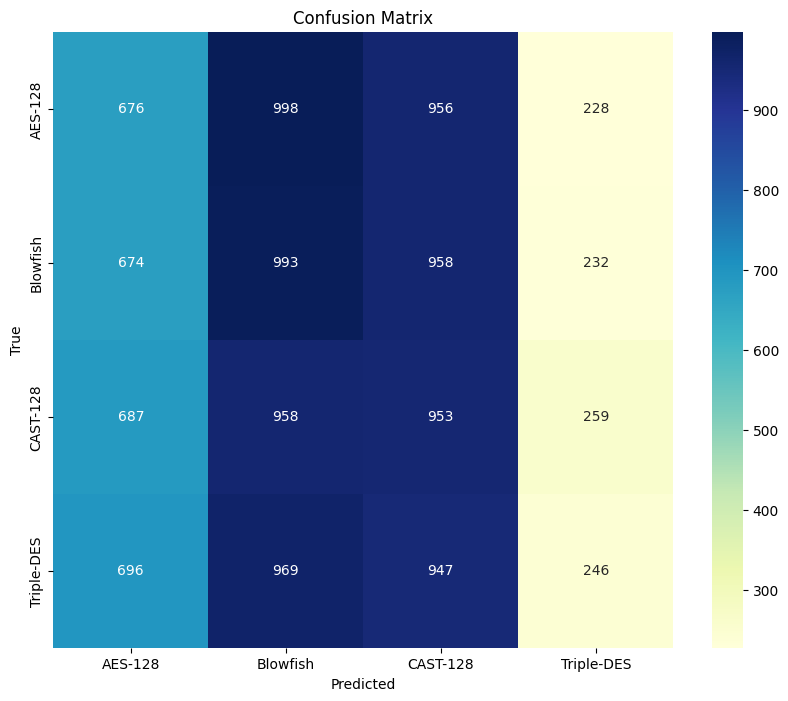

In [303]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Step 1: Preprocess the Dataset
# Label encoding the target variable
label_encoder = LabelEncoder()
df['algorithm_encoded'] = label_encoder.fit_transform(df[1])  # Adjust column name as necessary
X = df.drop(columns=['algorithm_encoded', 0, 1, 2, 3, 4])  # Adjust column names
y = df['algorithm_encoded']

# Step 2: Check Class Imbalance
print("Original class distribution:", Counter(y))

# Step 3: Shuffle and Split Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y, shuffle=True  # Shuffle the data
)

# Step 4: Feature Selection Using XGBoost-RFE
def xgboost_rfe_cpu(X, y, n_features_to_select=50):
    xgb_cpu = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',  # Use CPU-optimized method
        max_depth=4,  # Set the maximum depth of trees to reduce splits
        min_child_weight=5,  # Control the minimum sum of instance weight in a child
        random_state=42
    )
    rfe = RFE(estimator=xgb_cpu, n_features_to_select=n_features_to_select, step=1)
    X_selected = rfe.fit_transform(X, y)
    return X_selected, rfe.support_

X_train_selected, selected_features = xgboost_rfe_cpu(X_train, y_train, n_features_to_select=200)
X_test_selected = X_test.iloc[:, selected_features]

# Step 5: Define Base Models for Stacking
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',  # Use CPU-optimized method
    random_state=42
)

lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(Counter(y)),  # Number of unique classes
    device='cpu',  # Use CPU for LightGBM
    random_state=42
)

# Step 6: Define Stacking Model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# Step 7: Train the Model
stacking_model.fit(X_train_selected, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = stacking_model.predict(X_test_selected)

# Ensure `target_names` matches the unique classes in `y_test`
unique_classes = sorted(set(y_test))
class_names = label_encoder.inverse_transform(unique_classes)

# Print Classification Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [35]:
from scipy.fft import fft
from scipy.stats import entropy

def spectral_entropy(binary_string):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    fft_values = np.abs(fft(numeric_data))
    normalized_fft = fft_values / np.sum(fft_values)
    return entropy(normalized_fft)

def dominant_frequency_magnitude(binary_string):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    fft_values = np.abs(fft(numeric_data))
    return np.max(fft_values)

def power_spectral_density_peaks(binary_string, num_peaks=3):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    fft_values = np.abs(fft(numeric_data)) ** 2
    return sorted(fft_values, reverse=True)[:num_peaks]


In [36]:
def entropy_gradient(binary_string, block_size):
    entropies = []
    for i in range(0, len(binary_string), block_size):
        block = binary_string[i:i + block_size]
        counts = np.bincount([int(bit) for bit in block], minlength=2)
        probabilities = counts / counts.sum()
        entropies.append(-np.sum(probabilities * np.log2(probabilities + 1e-10)))
    return np.gradient(entropies)


In [37]:
def adjacent_bit_probability(binary_string):
    transitions = [1 if binary_string[i] != binary_string[i + 1] else 0 for i in range(len(binary_string) - 1)]
    return sum(transitions) / len(transitions)

def bit_pair_frequency(binary_string):
    pairs = [binary_string[i:i + 2] for i in range(len(binary_string) - 1)]
    return {pair: pairs.count(pair) / len(pairs) for pair in ['00', '01', '10', '11']}


In [38]:
import nolds

def hurst_exponent(binary_string):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    return nolds.hurst_rs(numeric_data)

def detrended_fluctuation_analysis(binary_string):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    return nolds.dfa(numeric_data)


In [39]:
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot

def recurrence_quantification_analysis(binary_string, threshold=0.5):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    rp = RecurrencePlot(numeric_data, threshold=threshold)
    return rp.recurrence_rate()


In [44]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# Functions for feature extraction


# Extract features for a single row
def extract_features_for_row(row, segment_sizes):
    features = {}
    binary_string = row[4]  # Column containing binary ciphertext

    for size in segment_sizes:
        # Extract the segment of the required size
        segment = binary_string[:size]
        segment = segment.ljust(size, '0')  # Pad with zeros if smaller than size

        # Compute features
        features[f"recurrence_rate_{size}"] = recurrence_quantification_analysis(segment)
        features[f"hurst_exponent_{size}"] = hurst_exponent(segment)
        features[f"dfa_{size}"] = detrended_fluctuation_analysis(segment)
        bit_freq = bit_pair_frequency(segment)
        for pair, freq in bit_freq.items():
            features[f"bit_pair_freq_{pair}_{size}"] = freq
        features[f"entropy_gradient_{size}"] = entropy_gradient(segment,8)
        features[f"adjacent_bit_probability_{size}"] = adjacent_bit_probability(segment)
        features[f"spectral_entropy_{size}"] = spectral_entropy(segment)
        features[f"dominant_frequency_magnitude_{size}"] = dominant_frequency_magnitude(segment)
        peaks = power_spectral_density_peaks(segment)
        for i, peak in enumerate(peaks):
            features[f"power_spectral_peak_{i+1}_{size}"] = peak

    return features

# Append features to the dataset
def append_features_to_dataset(dataset, segment_sizes=[128, 256, 512, 1024, 2048, 4096], n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_features_for_row)(row, segment_sizes) for _, row in dataset.iterrows()
    )
    features_df = pd.DataFrame(results)
    updated_dataset = pd.concat([dataset.reset_index(drop=True), features_df], axis=1)
    return updated_dataset


In [45]:
updated_df_1 = append_features_to_dataset(updated_df)


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculatin

/Users/inviforce/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculatin

/Users/inviforce/.pyenv/versions/3.8.12/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculatin

/Users/inviforce/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculatin

In [ ]:
updated_df.to_csv("new_df1.csv", index=False)

In [ ]:
import pandas as pd

In [ ]:
new_df=pd.read_csv("/content/drive/MyDrive/new_df1.csv")

In [46]:
updated_df_1.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,bit_pair_freq_01_4096,bit_pair_freq_10_4096,bit_pair_freq_11_4096,entropy_gradient_4096,adjacent_bit_probability_4096,spectral_entropy_4096,dominant_frequency_magnitude_4096,power_spectral_peak_1_4096,power_spectral_peak_2_4096,power_spectral_peak_3_4096
0,BlockCipher,AES-128,1.0,2b8f6d7c09fe573df6115b8a6a85f19728af532e73939a...,0000001000001011000010000000111100000110000011...,0.877437,0.406250,2.837252,0.994987,38,...,0.157753,0.157753,0.088645,"[0.41086955972536865, 0.0, 0.02278299853751747...",0.315507,8.096929,2078.0,4318084.0,1.691412e+06,1.691412e+06
1,BlockCipher,AES-192,1.0,2fa2773feeda4919537db42ce6c876fd9855e6f47ce4d6...,0000001000001111000010100000001000000111000001...,0.867507,0.421875,1.885618,1.064794,37,...,0.155800,0.155556,0.091819,"[0.4564355568004036, 0.13385684062976821, -0.2...",0.311355,8.100702,2068.0,4276624.0,1.805484e+06,1.805484e+06
2,BlockCipher,AES-256,1.0,64e0ea817c0bfbc7eb761c86a54b627d0657379a74629b...,0000011000000100000011100000000000001110000010...,0.823427,0.484375,3.614657,0.937493,33,...,0.154579,0.154579,0.087912,"[-0.26771368125953643, 0.07157793923291611, -0...",0.309158,8.096509,2110.0,4452100.0,1.663475e+06,1.663475e+06
3,BlockCipher,Triple-DES,1.0,4ccba0ff1515eb620acf133857440e9d0e5ee16d15e3a7...,0000010000001100000011000000101100001010000000...,0.823427,0.484375,2.872183,0.963068,33,...,0.153846,0.153846,0.090598,"[0.26771368125953643, 0.13385684062976821, 0.0...",0.307692,8.094917,2094.0,4384836.0,1.727337e+06,1.727337e+06
4,BlockCipher,Blowfish,1.0,7c434bc7896a391caf611c100f1cb9e8e92b5616d99dfe...,0000011100001100000001000000001100000100000010...,0.798659,0.515625,2.081121,0.668954,31,...,0.157021,0.156777,0.084493,"[-0.14315587846583222, -0.20543477986268432, 0...",0.313797,8.095917,2118.0,4485924.0,1.644161e+06,1.644161e+06


In [ ]:
import numpy as np

In [ ]:
copy_dfer=new_df.copy()

In [ ]:
new_df.head()

,0,1,2,3,algorithm,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,...,bit_pair_freq_01_4096,bit_pair_freq_10_4096,bit_pair_freq_11_4096,entropy_gradient_4096,adjacent_bit_probability_4096,spectral_entropy_4096,dominant_frequency_magnitude_4096,power_spectral_peak_1_4096,power_spectral_peak_2_4096,power_spectral_peak_3_4096
0,BlockCipher,AES-128,1,0ac1d7274c1f90b0f386d76bb84ef47990afc2c90e70c6...,AES-128_ 1,0000000000001010000011000000000100001101000001...,0.757878,0.562500,5.555556,1.647059,...,0.156288,0.156288,0.094261,[ 0.27077583 0.09300786 -0.13538791 0.022935...,0.312576,8.107188,2044.0,4177936.0,1.777366e+06,1.777366e+06
1,BlockCipher,Triple-DES,1,fb33c1f018339f01427793223992dc964bc04c064a98c8...,Triple-DES_ 1,0000111100001011000000110000001100001100000000...,0.798659,0.515625,6.062500,1.937500,...,0.145543,0.145543,0.093040,[-0.17048361 -0.11607491 0. 0.057532...,0.291087,8.093398,2142.0,4588164.0,1.695355e+06,1.695355e+06
2,BlockCipher,Blowfish,1,d3e59d4c6b095083075fe1620fa371fd496e008db1d0bf...,Blowfish_ 1,0000110100000011000011100000010100001001000011...,0.785560,0.531250,4.666667,1.428571,...,0.152137,0.151893,0.101099,[-0.08476011 -0.06907988 -0.09300786 0.049634...,0.304029,8.100660,2022.0,4088484.0,1.912901e+06,1.912901e+06
3,BlockCipher,CAST-128,1,7d29e9cc5422da3f2a3f69fae4dbdaa7f3ee17ec8bd96b...,CAST-128_ 1,0000011100001101000000100000100100001110000010...,0.835116,0.468750,4.272727,1.545455,...,0.153114,0.152869,0.094994,[ 0. -0.11594302 0.03560682 0.115943...,0.305983,8.103084,2064.0,4260096.0,1.782486e+06,1.782486e+06
4,BlockCipher,AES-128,2,a3aa833397ceb8ecb3d564a537928ae1f43da04973783b...,AES-128_ 2,0000101000000011000010100000101000001000000000...,0.835116,0.468750,4.272727,1.619048,...,0.160684,0.160684,0.094017,[-0.05339966 0.04238005 0.04963499 0. ...,0.321368,8.110214,2010.0,4040100.0,1.832733e+06,1.832733e+06


In [ ]:
df=new_df[new_df['0']=="StreamCipher"]

In [ ]:
import numpy as np
import pandas as pd
import ast

def parse_and_convert_column1(column):
    """
    Converts a string representation of a list into a numpy array with comma-separated values.
    Handles strings with newline characters and preserves the input if parsing fails.
    """
    def convert_string_to_array(value):
        """
        Converts a string representation of a list into a numpy array of floats.
        Handles newline characters and spaces.
        """
        if isinstance(value, str):
            try:
                # Remove newline characters and extra spaces
                cleaned_value = value.replace('\n', ' ').replace('[', '').replace(']', '').strip()
                # Parse the string into a list of numbers
                parsed_value = [float(x) for x in cleaned_value.split()]
                # Convert to numpy array if the parsed value is a list
                return np.array(parsed_value, dtype=float)
            except Exception as e:
                print(f"Error parsing value: {value} -> {e}")
                return value  # Return the original value if parsing fails
        return value  # Return the value as is if it's not a string

    # Apply conversion to the column
    converted_column = column.apply(convert_string_to_array)
    print(f"Column after conversion:\n{converted_column.head()}")  # Debugging step
    return converted_column

def convert_dataframe(df):
    """
    Converts specific columns containing stringified lists to numpy arrays with comma-separated values.
    Preserves specified columns like '0', '1', '2', '3', 'algorithm', and '4'.
    """
    # Columns to preserve
    preserved_columns = ['0', '1', '2', '3', 'algorithm', '4']

    # Iterate through columns, convert only those not in the preserved list
    for column in df.columns:
        if column not in preserved_columns:
            print(f"Processing column: {column}")  # Debugging step
            df[column] = parse_and_convert_column1(df[column])  # Assign the converted column back to the DataFrame

    return df  # Return the modified DataFrame

In [ ]:
new_df['wavelet_mean_level_2_512']

,wavelet_mean_level_2_512
0,0.000000
1,-0.011049
2,0.011049
3,0.000000
4,-0.011049
...,...
25020,0.000000
25021,0.000000
25022,0.000000
25023,0.000000


In [ ]:
que_df=convert_dataframe(copy_dfer)

Processing column: entropy_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: entropy_128, dtype: object
Processing column: frequency_deviation_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: frequency_deviation_128, dtype: object
Processing column: mean_run_0_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: mean_run_0_128, dtype: object
Processing column: mean_run_1_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: mean_run_1_128, dtype: object
Processing column: hamming_weight_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: hamming_weight_128, dtype: object
Processing column: bit_transitions_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: bit_transitions_128, dtype: object
Processing column: skewness_128
Column after conversion:
0    None
1    None
2    None
3    None
4  

In [ ]:
que_df.describe()

,0,1,2,3,algorithm,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,...,bit_pair_freq_01_4096,bit_pair_freq_10_4096,bit_pair_freq_11_4096,entropy_gradient_4096,adjacent_bit_probability_4096,spectral_entropy_4096,dominant_frequency_magnitude_4096,power_spectral_peak_1_4096,power_spectral_peak_2_4096,power_spectral_peak_3_4096
count,25025,25025,25025,25025,25025,25025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unique,3,9,6,25025,25,25025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
top,BlockCipher,AES-128,None,41eed67d380a33cf9060e948ef2f49ceb87b082b8cd5f0...,AES-128_ 1,0000010000000001000011100000111000001101000001...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20020,5005,5005,1,1001,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
copy_dfer['entropy_gradient_2048'][0]

In [ ]:
new_df=que_df.copy()

In [ ]:
new_df['entropy_gradient_2048'][0]

'[ 0.27077583  0.09300786 -0.13538791  0.02293516  0.15154983 -0.02293516\n -0.01616192  0.         -0.06907988 -0.05753293  0.02669983  0.\n  0.04238005  0.0308331  -0.22358687  0.          0.12367389  0.02669983\n  0.          0.02293516  0.0308331  -0.11594302  0.02669983  0.03547493\n  0.08160564  0.0308331  -0.02306367  0.04963499 -0.15154983 -0.156792\n  0.03547493  0.10715701  0.          0.09827777  0.0308331  -0.07157794\n  0.06907988  0.04238005 -0.09991299 -0.04238005  0.08046809  0.02293516\n -0.04963499  0.03560682  0.0852418  -0.11607491 -0.0852418   0.09991299\n  0.         -0.04238005  0.04963499  0.07157794 -0.02293516 -0.09827777\n -0.02669983  0.          0.02669983 -0.0308331  -0.02669983  0.08046809\n  0.06907988  0.0194449   0.01616192  0.03232384]'

In [ ]:
import pandas as pd

In [ ]:
new_df.head()

NameError: name 'new_df' is not defined

In [1]:
import pandas as pd

In [3]:
df=pd.read_csv("new_df1_12.csv")

In [4]:
df.head()

,0,1,2,3,algorithm,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,...,bit_pair_freq_01_4096,bit_pair_freq_10_4096,bit_pair_freq_11_4096,entropy_gradient_mean_4096,entropy_gradient_std_4096,adjacent_bit_probability_4096,spectral_entropy_4096,dominant_frequency_magnitude_4096,power_spectral_peak_mean_4096,power_spectral_peak_std_4096
0,BlockCipher,AES-128,1,0ac1d7274c1f90b0f386d76bb84ef47990afc2c90e70c6...,AES-128_ 1,0000000000001010000011000000000100001101000001...,0.757878,0.562500,5.555556,1.647059,...,0.156288,0.156288,0.094261,0.797594,0.097619,0.312576,8.107188,2044.0,2.577556e+06,1.131639e+06
1,BlockCipher,Triple-DES,1,fb33c1f018339f01427793223992dc964bc04c064a98c8...,Triple-DES_ 1,0000111100001011000000110000001100001100000000...,0.798659,0.515625,6.062500,1.937500,...,0.145543,0.145543,0.093040,0.776186,0.113530,0.291087,8.093398,2142.0,2.659624e+06,1.363683e+06
2,BlockCipher,Blowfish,1,d3e59d4c6b095083075fe1620fa371fd496e008db1d0bf...,Blowfish_ 1,0000110100000011000011100000010100001001000011...,0.785560,0.531250,4.666667,1.428571,...,0.152137,0.151893,0.101099,0.799202,0.105861,0.304029,8.100660,2022.0,2.638095e+06,1.025580e+06
3,BlockCipher,CAST-128,1,7d29e9cc5422da3f2a3f69fae4dbdaa7f3ee17ec8bd96b...,CAST-128_ 1,0000011100001101000000100000100100001110000010...,0.835116,0.468750,4.272727,1.545455,...,0.153114,0.152869,0.094994,0.788247,0.117146,0.305983,8.103084,2064.0,2.608356e+06,1.167956e+06
4,BlockCipher,AES-128,2,a3aa833397ceb8ecb3d564a537928ae1f43da04973783b...,AES-128_ 2,0000101000000011000010100000101000001000000000...,0.835116,0.468750,4.272727,1.619048,...,0.160684,0.160684,0.094017,0.804364,0.094466,0.321368,8.110214,2010.0,2.568522e+06,1.040563e+06


In [5]:
new_df=df.copy()

Original class distribution: Counter({0: 5005, 8: 5005, 3: 5005, 4: 5005, 2: 1001, 6: 1001, 1: 1001, 5: 1001, 7: 1001})
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22947
[LightGBM] [Info] Number of data points in the train set: 15015, number of used features: 200
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -3.219875
[LightGBM] [Info] Start training from score -3.218210
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -3.218210
[LightGBM] [Info] Start training from score -3.219875
[LightGBM] [Info] Start training from score -3.218210
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

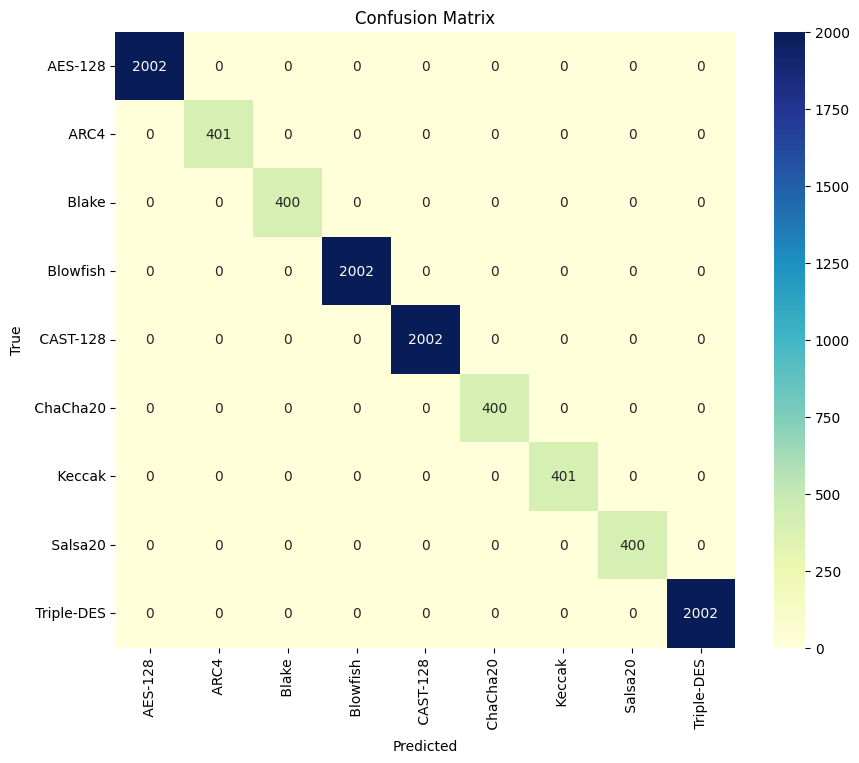

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import multiprocessing

# Get the number of available CPU threads
num_threads = multiprocessing.cpu_count()

# Step 1: Preprocess the Dataset
# Label encoding the target variable
label_encoder = LabelEncoder()
new_df['algorithm_encoded'] = label_encoder.fit_transform(new_df['1'])  # Adjust column name as necessary
X = new_df.drop(columns=['algorithm', 'algorithm_encoded', '0', '1', '2', '3', '4'])  # Adjust column names
y = new_df['algorithm_encoded']

# Step 2: Check Class Imbalance
print("Original class distribution:", Counter(y))

# Step 3: Shuffle and Split Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y, shuffle=True  # Shuffle the data
)

# Step 4: Feature Selection Using XGBoost-RFE
def xgboost_rfe_cpu(X, y, n_features_to_select=50):
    xgb_cpu = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',  # Use histogram-based tree growth for CPU
        max_depth=4,  # Set the maximum depth of trees to reduce splits
        min_child_weight=5,  # Control the minimum sum of instance weight in a child
        random_state=42,
        n_jobs=num_threads  # Use all available threads
    )
    rfe = RFE(estimator=xgb_cpu, n_features_to_select=n_features_to_select, step=1)
    X_selected = rfe.fit_transform(X, y)
    return X_selected, rfe.support_

X_train_selected, selected_features = xgboost_rfe_cpu(X_train, y_train, n_features_to_select=200)
X_test_selected = X_test.iloc[:, selected_features]

# Step 5: Define Base Models for Stacking
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',  # Use CPU-compatible tree method
    random_state=42,
    n_jobs=num_threads  # Use all available threads
)

lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(Counter(y)),  # Number of unique classes
    random_state=42,
    n_jobs=num_threads  # Use all available threads
)

# Step 6: Define Stacking Model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000, n_jobs=num_threads),
    cv=5
)

# Step 7: Train the Model
stacking_model.fit(X_train_selected, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = stacking_model.predict(X_test_selected)

# Ensure `target_names` matches the unique classes in `y_test`
unique_classes = sorted(set(y_test))
class_names = label_encoder.inverse_transform(unique_classes)

# Print Classification Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import joblib

# Save the model to a file
joblib.dump(stacking_model, '/content/drive/MyDrive/Model-Sih-1/stacking1_total_stream_model.pkl')

# Load the model back
loaded_model = joblib.load('/content/drive/MyDrive/Model-Sih-1/stacking1_total_model.pkl')

# Use the loaded model for predictions
y_pred = loaded_model.predict(X_test_selected)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:38:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [62]:
updated_df.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,wavelet_energy_level_2_4096,wavelet_entropy_level_2_4096,wavelet_mean_level_3_4096,wavelet_std_level_3_4096,wavelet_energy_level_3_4096,wavelet_entropy_level_3_4096,wavelet_mean_level_4_4096,wavelet_std_level_4_4096,wavelet_energy_level_4_4096,wavelet_entropy_level_4_4096
0,BlockCipher,AES-128,1.0,2b8f6d7c09fe573df6115b8a6a85f19728af532e73939a...,0000001000001011000010000000111100000110000011...,0.877437,0.406250,2.837252,0.994987,38,...,1237.5,497.171056,-0.008789,0.700809,503.0,12.0,-0.003453,0.718742,1058.0,3.535534
1,BlockCipher,AES-192,1.0,2fa2773feeda4919537db42ce6c876fd9855e6f47ce4d6...,0000001000001111000010100000001000000111000001...,0.867507,0.421875,1.885618,1.064794,37,...,1261.0,509.011639,-0.015625,0.688742,486.0,-4.0,-0.016573,0.715153,1048.0,16.970563
2,BlockCipher,AES-256,1.0,64e0ea817c0bfbc7eb761c86a54b627d0657379a74629b...,0000011000000100000011100000000000001110000010...,0.823427,0.484375,3.614657,0.937493,33,...,1208.5,477.531563,-0.045898,0.730771,549.0,32.0,-0.002072,0.700861,1006.0,2.121320
3,BlockCipher,Triple-DES,1.0,4ccba0ff1515eb620acf133857440e9d0e5ee16d15e3a7...,0000010000001100000011000000101100001010000000...,0.823427,0.484375,2.872183,0.963068,33,...,1241.5,497.115760,-0.026367,0.705924,511.0,4.0,0.000691,0.702256,1010.0,-0.707107
4,BlockCipher,Blowfish,1.0,7c434bc7896a391caf611c100f1cb9e8e92b5616d99dfe...,0000011100001100000001000000001100000100000010...,0.798659,0.515625,2.081121,0.668954,31,...,1204.5,475.930205,0.000977,0.710550,517.0,-6.0,-0.039360,0.708082,1030.0,40.305086


In [ ]:
updated_df

In [65]:

# Define features and target
label_encoder = LabelEncoder()
y = updated_df[1] 
X = updated_df.drop(columns=[ 0,1, 2, 3,4])  # Drop the target column to get the features
 # Target variable (e.g., AES-128, Triple-DES, etc.)
y_encoded = label_encoder.fit_transform(y)
y=y_encoded
# Split into training+validation and test sets

# Further split training+validation into training and validation sets


In [66]:
y_encoded

array([ 0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,
        6,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  4,  8,  3,  7,
        9,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,
        5,  6,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  4,  8,  3,
        7,  9,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  0,  1,  2,
       10,  5,  6,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  4,  8,
        3,  7,  9,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  0,  1,
        2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  4,
        8,  3,  7,  9,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  0,
        1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,  0,  1,  2, 10,  5,  6,
        4,  8,  3,  7,  9])

In [58]:
updated_df.head()

,0,1,2,3,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,hamming_weight_128,...,wavelet_energy_level_2_4096,wavelet_entropy_level_2_4096,wavelet_mean_level_3_4096,wavelet_std_level_3_4096,wavelet_energy_level_3_4096,wavelet_entropy_level_3_4096,wavelet_mean_level_4_4096,wavelet_std_level_4_4096,wavelet_energy_level_4_4096,wavelet_entropy_level_4_4096
0,BlockCipher,AES-128,1.0,2b8f6d7c09fe573df6115b8a6a85f19728af532e73939a...,0000001000001011000010000000111100000110000011...,0.877437,0.406250,2.837252,0.994987,38,...,1237.5,497.171056,-0.008789,0.700809,503.0,12.0,-0.003453,0.718742,1058.0,3.535534
1,BlockCipher,AES-192,1.0,2fa2773feeda4919537db42ce6c876fd9855e6f47ce4d6...,0000001000001111000010100000001000000111000001...,0.867507,0.421875,1.885618,1.064794,37,...,1261.0,509.011639,-0.015625,0.688742,486.0,-4.0,-0.016573,0.715153,1048.0,16.970563
2,BlockCipher,AES-256,1.0,64e0ea817c0bfbc7eb761c86a54b627d0657379a74629b...,0000011000000100000011100000000000001110000010...,0.823427,0.484375,3.614657,0.937493,33,...,1208.5,477.531563,-0.045898,0.730771,549.0,32.0,-0.002072,0.700861,1006.0,2.121320
3,BlockCipher,Triple-DES,1.0,4ccba0ff1515eb620acf133857440e9d0e5ee16d15e3a7...,0000010000001100000011000000101100001010000000...,0.823427,0.484375,2.872183,0.963068,33,...,1241.5,497.115760,-0.026367,0.705924,511.0,4.0,0.000691,0.702256,1010.0,-0.707107
4,BlockCipher,Blowfish,1.0,7c434bc7896a391caf611c100f1cb9e8e92b5616d99dfe...,0000011100001100000001000000001100000100000010...,0.798659,0.515625,2.081121,0.668954,31,...,1204.5,475.930205,0.000977,0.710550,517.0,-6.0,-0.039360,0.708082,1030.0,40.305086


In [ ]:
loaded_model = joblib.load('stacking1_total_model.pkl')

# Use the loaded model for predictions
y_pred = loaded_model.predict(X_test_selected)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib

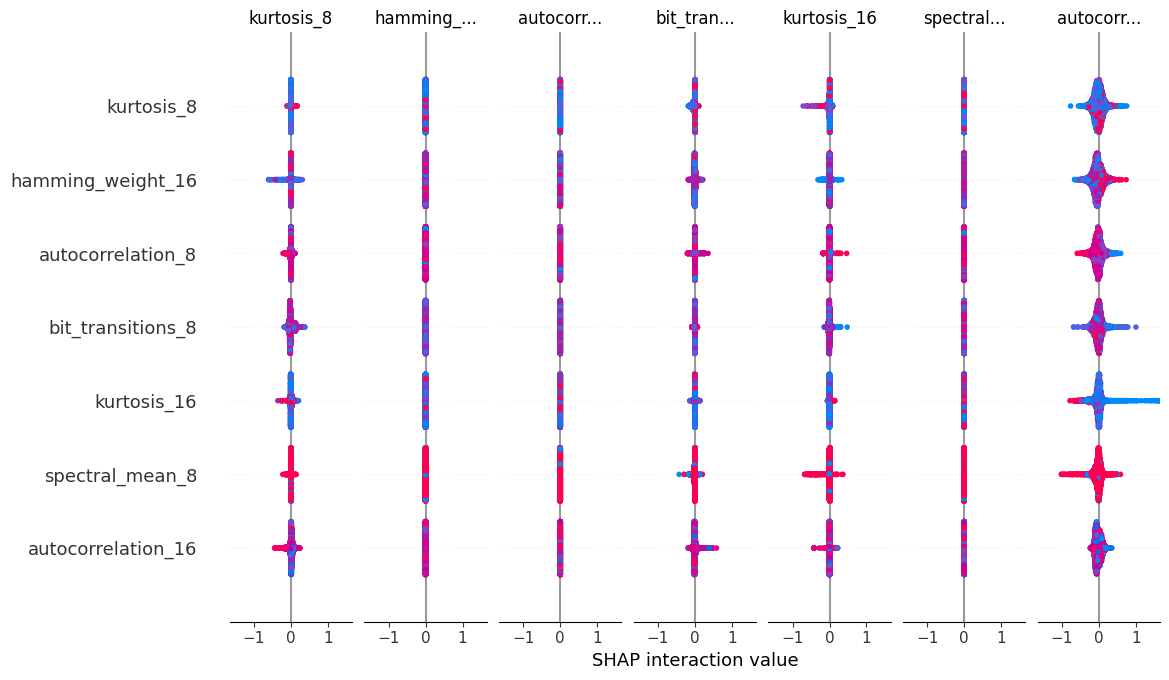

In [ ]:
import shap
import xgboost as xgb

# Train an XGBoost model with GPU support
model = xgb.XGBClassifier(
    eval_metric='mlogloss',
    tree_method='hist',  # Use histogram method (compatible with both CPU and GPU)
    device='cuda'        # Explicitly set to use GPU
)
model.fit(X_train, y_train)

# Explain model predictions using SHAP
explainer = shap.TreeExplainer(model)  # SHAP will automatically leverage GPU for XGBoost models on CUDA
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Load dataset
df = updated_dataset  # Use the dataset with extracted features

# Define features and target
X = df.drop(columns=["algorithm", 0, 1, 2, 3,4]) # Feature matrix
y = pd.get_dummies(df["algorithm"])  # One-hot encode target variable

# Split dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["algorithm"])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val.values.argmax(axis=1))

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the DNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

# Save the trained model
model_path = "dnn_model.h5"
model.save(model_path)
print(f"DNN Model saved to {model_path}")

# Load the model
loaded_model = load_model(model_path)

# Evaluate the loaded model on the test set
y_test_pred = loaded_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test.values, axis=1)

print("\nTest Set Classification Report:\n", classification_report(y_test_true_classes, y_test_pred_classes))
print("Test Set Accuracy Score:", accuracy_score(y_test_true_classes, y_test_pred_classes))


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
updated_dataset=pd.read_csv("/content/drive/MyDrive/encypted_csv_66500.csv")

In [ ]:
updated_dataset.shape

(65114, 342)

In [ ]:
new_df=updated_dataset.copy()

In [ ]:
def remove_missing_features(dataset, segment_sizes):
    """
    Remove additional features introduced in the second code from the dataset.

    Parameters:
        dataset (pd.DataFrame): Dataset containing features.
        segment_sizes (list): List of segment sizes.

    Returns:
        pd.DataFrame: Updated dataset with specified features removed.
    """
    # Features to remove (fixed missing commas)
    features_to_remove = [
        "fractal_dimension",
        "complexity",
        "spectral_mean",
        "spectral_variance",
        "spectral_entropy",
        "entropy_gradient_mean",
        "convolution",
        #"convolution_mean",
        "power_spectral_peak",
        "hamming_weight",
        "adjacent_bit_probability",
        "bit_transitions",
        "dominant_frequency_magnitude",
        # "bit_pair_freq",
        "hurst_exponent",
        "recurrence_rate",
        "dfa",
        "skewness",
        "frequency_deviation",
        "mean_run_0",
        "mean_run_1",
        "entropy",
        "autocorrelation",
        "chi_square"
    ]

    # Generate column names to remove
    columns_to_remove = []
    for feature in features_to_remove:
        for size in segment_sizes:
            if feature == "power_spectral_peak":
                # Handle multiple peaks (e.g., power_spectral_peak_1, power_spectral_peak_2, ...)
                columns_to_remove.extend([col for col in dataset.columns if col.startswith(f"{feature}_") and col.endswith(f"_{size}")])
            else:
                columns_to_remove.append(f"{feature}_{size}")

    # Drop the columns from the dataset (ignore missing columns)
    dataset = dataset.drop(columns=columns_to_remove, )
    return dataset



In [ ]:
# Dataset with all features

# Segment sizes used for feature extraction
segment_sizes = [128, 256, 512, 1024, 2048, 4096]

# Remove the additional features
cleaned_dataset = remove_missing_features(updated_dataset, segment_sizes)


In [ ]:
cleaned_dataset.shape

(25025, 169)

In [ ]:
cleaned_dataset[2].apply(len).unique()

(222,)

In [ ]:
import pandas as pd

# Example: Assume 'cleaned_dataset' is your DataFrame
# cleaned_dataset = pd.DataFrame(...)  # Your dataset

# Convert the column names to a DataFrame for better display
column_names = pd.DataFrame(cleaned_dataset.columns, columns=["Column Names"])

# Display the complete list using pd.display
pd.set_option('display.max_rows', None)  # Ensures all rows are shown
display(column_names)  # Will display all column names in a scrollable format


,Column Names
0,0
1,1
2,2
3,3
4,algorithm
5,4
6,kurtosis_128
7,kurtosis_256
8,kurtosis_512
9,kurtosis_1024


In [ ]:
new_df=cleaned_dataset.copy()

In [ ]:
new_df

,0,1,2,3,length,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,...,fractal_dimension_4096,spectral_mean_4096,spectral_variance_4096,bit_pair_freq_00_4096.1,bit_pair_freq_01_4096.1,bit_pair_freq_10_4096.1,bit_pair_freq_11_4096.1,complexity_4096,entropy_gradient_4096,spectral_entropy_4096
0,BlockCipher,AES-128,1.0,29d11f6c2a70a9b22d57347d525237c8e5819370a87b25...,5408,0010100111010001000111110110110000101010011100...,0.999295,0.031250,1.736842,1.675676,...,-0.961068,4096.0,15858752.0,0.254212,0.246154,0.246154,0.253480,719,0.000276,8.182264
1,BlockCipher,AES-192,1.0,72dca4a4ed094521869119f61751f7fbe7ba7935499ef9...,5408,0111001011011100101001001010010011101101000010...,1.000000,0.000000,1.882353,1.882353,...,-0.965641,4096.0,15887952.0,0.237607,0.259341,0.259096,0.243956,718,-0.000092,8.184306
2,BlockCipher,AES-256,1.0,af71e96f730b60dda1417e109e434ab7a29d3383e62ce0...,5408,1010111101110001111010010110111101110011000010...,0.999295,0.031250,1.937500,2.000000,...,-0.962184,4096.0,15961040.0,0.250794,0.243468,0.243712,0.262027,718,-0.000396,8.180122
3,BlockCipher,Triple-DES,1.0,017ae9e96df3ec2e086cfd56eb13901c09d43582953b5e...,5408,0000000101111010111010011110100101101101111100...,0.999295,0.031250,2.000000,2.200000,...,-0.964555,4096.0,16727664.0,0.239560,0.253480,0.253236,0.253724,727,0.001373,8.174657
4,BlockCipher,Blowfish,1.0,df805cc5ac19cfe10897c9308bf73b6ab147a79ca5e65a...,5408,1101111110000000010111001100010110101100000110...,0.999824,0.015625,2.172414,2.241379,...,-0.961327,4096.0,16920144.0,0.258120,0.248352,0.248596,0.244933,719,-0.000488,8.175950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65109,BlockCipher,AES-128,1.0,cc22dc6d2c1d524f92982558988f97430d4648e0b15d9d...,6592,1100110000100010110111000110110100101100000111...,0.995593,0.078125,2.029412,1.685714,...,-0.960637,4096.0,16084080.0,0.257875,0.252991,0.253236,0.235897,717,-0.000977,8.185648
65110,BlockCipher,AES-192,1.0,ffbcc292cf4777d791183e2ca89f455da92236b8b3aa20...,6592,1111111110111100110000101001001011001111010001...,0.991353,0.109375,1.838710,2.218750,...,-0.962013,4096.0,18389376.0,0.246886,0.242491,0.242491,0.268132,715,0.001069,8.169342
65111,BlockCipher,AES-256,1.0,87803fdbb86a76493d7c56146c53df69847c07998ac726...,6592,1000011110000000001111111101101110111000011010...,0.997180,0.062500,2.000000,2.193548,...,-0.962098,4096.0,16517312.0,0.255189,0.246398,0.246398,0.252015,708,-0.001188,8.180907
65112,BlockCipher,Triple-DES,1.0,a43bd4727caaeb1b51e9f677ca243c6269269721a98762...,6576,1010010000111011110101000111001001111100101010...,0.997180,0.062500,1.764706,2.000000,...,-0.962440,4096.0,17745664.0,0.247863,0.249328,0.249328,0.253480,709,-0.000276,8.174236


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Original class distribution: Counter({0: 9866, 1: 9866, 2: 9866, 8: 9866, 4: 9866, 5: 9865, 3: 1973, 6: 1973, 7: 1973})


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:42:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:42:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:42:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:42:35] WARNING: /workspace/src/common/

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False  True False False False False False
 False False False False False False False  True False False False False
 False  True False False False  True False  True False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False  True False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False Fa

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:00:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:00:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11740
[LightGBM] [Info] Number of data points in the train set: 52091, number of used features: 50
[LightGBM] [Info] Start training from score -1.887016
[LightGBM] [Info] Start training from score -1.887016
[LightGBM] [Info] Start training from score -1.887016
[LightGBM] [Info] Start training from score -3.496834
[LightGBM] [Info] Start training from score -1.887016
[LightGBM] [Info] Start training from score -1.887143
[LightGBM] [Info] Start training from score -3.496834
[LightGBM] [Info] Start training from score -3.496834
[LightGBM] [Info] Start training from score -1.887016


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:00:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:00:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:00:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:00:34] WARNING: /workspac

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11704
[LightGBM] [Info] Number of data points in the train set: 41672, number of used features: 50
[LightGBM] [Info] Start training from score -1.887060
[LightGBM] [Info] Start training from score -1.886902
[LightGBM] [Info] Start training from score -1.886902
[LightGBM] [Info] Start training from score -3.497132
[LightGBM] [Info] Start training from score -1.887060
[LightGBM] [Info] Start training from score -1.887060
[LightGBM] [Info] Start training from score -3.497132
[LightGBM] [Info] Start training from score -3.497132
[LightGBM] [Info] Start training from score -1.887060
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11696
[LightGBM] [Info] Number of

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:00:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy: 0.15196191353758734
Classification Report:
               precision    recall  f1-score   support

     AES-128       0.16      0.13      0.14      1973
     AES-192       0.15      0.22      0.18      1973
     AES-256       0.15      0.17      0.16      1973
        ARC4       0.00      0.00      0.00       395
    Blowfish       0.14      0.14      0.14      1973
    CAST-128       0.16      0.25      0.19      1973
    ChaCha20       0.00      0.00      0.00       395
     Salsa20       0.00      0.00      0.00       395
  Triple-DES       0.15      0.11      0.13      1973

    accuracy                           0.15     13023
   macro avg       0.10      0.11      0.10     13023
weighted avg       0.14      0.15      0.14     13023



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


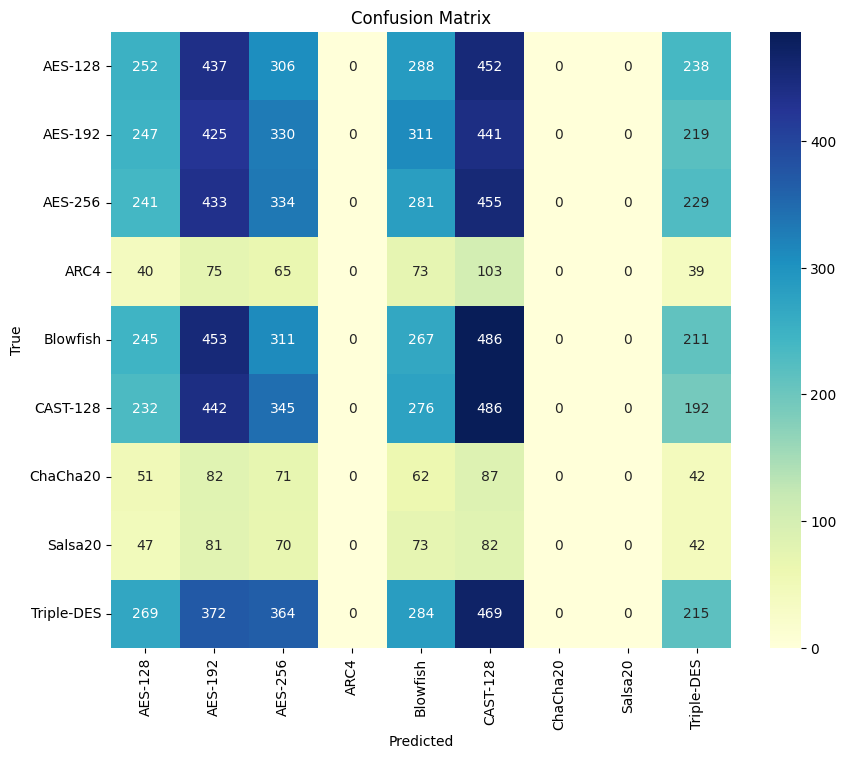

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Step 1: Preprocess the Dataset
# Label encoding the target variable
label_encoder = LabelEncoder()
new_df['algorithm_encoded'] = label_encoder.fit_transform(new_df['1'])  # Adjust column name as necessary
X = new_df.drop(columns=['length', 'algorithm_encoded', '0', '1', '2', '3', '4'])  # Adjust column names
y = new_df['algorithm_encoded']

# Step 2: Check Class Imbalance
print("Original class distribution:", Counter(y))

# Step 3: Split Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Feature Selection Using XGBoost-RFE
def xgboost_rfe_gpu(X, y, n_features_to_select=80):
    xgb_gpu = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
    rfe = RFE(estimator=xgb_gpu, n_features_to_select=n_features_to_select, step=1)
    X_selected = rfe.fit_transform(X, y)
    return X_selected, rfe.support_

X_train_selected, selected_features = xgboost_rfe_gpu(X_train, y_train, n_features_to_select=50)
print(selected_features)
X_test_selected = X_test.iloc[:, selected_features]

# Step 5: Define Base Models for Stacking
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(Counter(y)),  # Number of unique classes
    device='cpu',  # Use CPU for LightGBM
    random_state=42
)

# Step 6: Define Stacking Model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# Step 7: Train the Model
stacking_model.fit(X_train_selected, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = stacking_model.predict(X_test_selected)

# Ensure `target_names` matches the unique classes in `y_test`
unique_classes = sorted(set(y_test))
class_names = label_encoder.inverse_transform(unique_classes)

# Print Classification Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
new_df.shape

(25025, 169)